# Graph Analysis For Lead Generation/Targeted Advertising

So far we've managed to collect a lot of Twitter data, explore that data, and eventually create a topic model of tweets in order to sort tweets based on what was being discussed in that particular tweet. Of course, that only takes us so far. We now know which users are talking about a particular topic, but how do we use this data to generate leads or for advertising purposes? 

Well, we have already identified users which write tweets relevant to a topic of our choosing - how do we then take these users and find others with a shared interest? Well, we can take a look at the people who follow those users. With enough data - we can discover which users have the most reach - which users are most "influential" around a topic of our choosing. In this case, we have to define these relationships on a graph.

As we're missing tweets which did not include a location tag, this analysis will demonstrate how we may 

## Special Note

We don't recommend you use any conclusions from this notebook you may draw for anything but a learning experience. Due to time and accessibility constraints, we're working with a highly truncated data set of Twitter followers/tweets. As such, any conclusions and analysis in this notebook are "correct" within the scope of the dataset we used here - but in reality this analysis is considerably limited. The methodologies used however, could be easily expanded to a larger, more complete, data set from which realistic conclusions can be drawn. 

## Blurb about graphs probably

1. Graphs have nodes and edges
2. they show how things are related i guess
3. direced and un directed
4. You can call people edge lords



---

In [ ]:
# Fresh installs of packages users won't have here (also restart kernel for them )

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import json
import pandas as pd
import time
import networkx as nx
from pyvis import network as net 
from operator import itemgetter
from collections import OrderedDict
import numpy as np

# Getting User Information 

In the previous notebook, we identified users which were tweeting in specific topics. From this, it is clear that these users are interested in our topic of interest based on the content that they typically tweet. Now, we could certainly target those users with our content/advertisements/proposals - however they may not have our desired outreach. Not to mention, there may be too many of them and ideally we'd like to have to deliver our content directly to the fewest number of people possible - while reaching the maximum number of people. To do this task, we first grab a list of each of our identified "topic users" followers. 

**Note: Due to API limitations of free Twitter services, we only gather up to 250 followers for each user**

Our first step is to download the user information that we gathered using [this twitter bot](UserInfoGather.ipynb), which is stored as a JSON (JavaScript Object Notation) object. Let's download it and look at the data that we have available on each Twitter user. In this case, we've downloaded up to 250 followers of each user which had a tweet appear in a given topic more than once. In this way, we can see up two degrees of separation between each of our "influencers" as identified by our topic model. However, we note again that by only gathering up to 250 of each users followers we're presented with a significantly limited data set. 

In [2]:
with open('topic_users.json') as json_data:
    followers_dict = json.load(json_data)
    
key = list(followers_dict.keys())[0]
followers_dict[key][0]

{'blocked_by': False,
 'blocking': False,
 'contributors_enabled': False,
 'created_at': 'Sat Jan 12 17:27:25 +0000 2019',
 'default_profile': False,
 'default_profile_image': False,
 'description': '😸*ridi si sapis*🦉 ____ 🇨🇦Ye Olde Diogenes💡 ___ 🌈"Thunder on! Stride on, Democracy! Strike with vengeful stroke!"~Whitman🗽 ___ 🎶"Just like that bluebird"~Bowie⚡️',
 'entities': {'description': {'urls': []}},
 'favourites_count': 7320,
 'follow_request_sent': False,
 'followers_count': 17,
 'following': False,
 'friends_count': 177,
 'geo_enabled': False,
 'has_extended_profile': False,
 'id': 1084139799525707776,
 'id_str': '1084139799525707776',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': 'en',
 'listed_count': 0,
 'live_following': False,
 'location': 'Canada gally11saku',
 'muting': False,
 'name': 'clowncarbuncle_519EM',
 'notifications': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.p

Where we actually have a lot of information about each user provided. From their profile picture, to their profile customization settings. Essentially what we have is a text description of each users public profile information. 


## Data Format 

In the above data set we have what is known as a `dictionary` where in we can access information based on a named key. In the data set above, our dictionary is formatted as such

```python3
    {
        'User1' : ["UserObject11, UserObject12, ..., UserObject1N],
        'User2' : ["UserObject21, UserObject22, ..., UserObject2N],
        ...
        'UserN' : ["UserObjectN1, UserObjectN2, ..., UserObjectNN]
    }
```
Where the `"UserN"` strings are the screen name of users we identified within our topic model, and the list after the colon is the list of that users followers user JSON object.


## Where do our users reside? 

There's a lot of analysis we could do using this information - however for the most part we are only going to look at user names and follower relations. However, it is also important to take a look at the information each user has provided us in terms of their location. This is done in the cell below. 

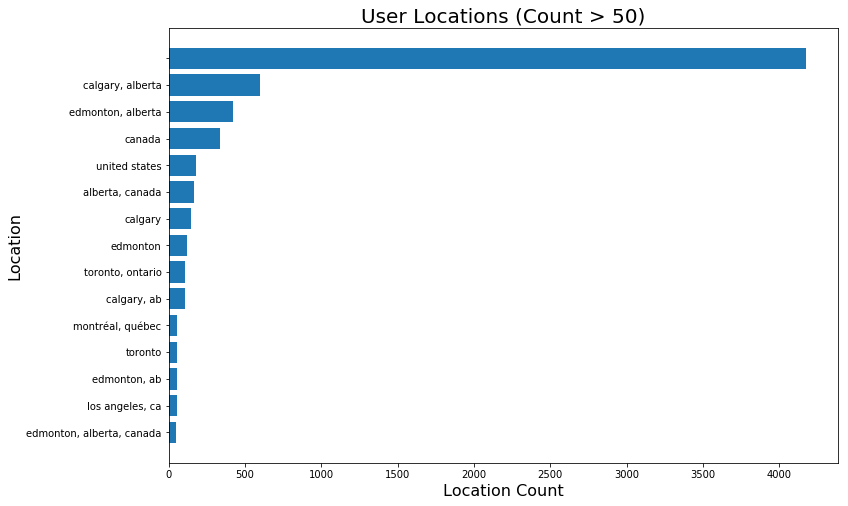

In [3]:
locs = []

for users in followers_dict.keys():
    for follower in followers_dict[users]:
        locs.append(follower['location'].lower())

locations_counted = Counter(locs).most_common()

y = []
x = []
for i in range(len(locations_counted)):
    if locations_counted[i][1] > 50:
        x.append(locations_counted[i][0])
        y.append(locations_counted[i][1])

plt.figure(figsize=(12,8))
plt.barh(x[::-1],y[::-1]) 
plt.xlabel("Location Count", size = 16)
plt.ylabel("Location", size = 16)
plt.title("User Locations (Count > 50)",size = 20)
plt.show()

Where the first bar with no label is the users who have not provided their location to Twitter's public data - and therefore we don't get to know their location. But for the most part these locations make sense - the majority with listed locations are from Alberta, our search box. However, we have other user locations in the above. These are likely the result of either tourists, or someone deciding to tweet from a location they are not currently in, as Twitter provides this functionality. 

# Finding your "Influencers" 

Certainly, we could take the naive approach and simply look for the user in our data set with the most followers like so

In [325]:

follower_count = {}
for users in followers_dict.keys():
    for follower in followers_dict[users]:
        follower_count[follower['screen_name']]  = follower['followers_count']
            
        if users == "RedMilePodcast":
            a = follower['screen_name']
            if "Z" in a:
                print(a)
        

power_users = sorted(follower_count.items(), key=itemgetter(1), reverse=True)[:10]
power_users_counts =np.sum([i[1] for i in power_users])


print("Totaly followers of our top 10 users", power_users_counts)
power_users

Zubes21
RealOZPodcast
ZachBoychuk
Totaly followers of our top 10 users 22741483


[('benlandis', 3405548),
 ('MixMastaKing', 2743606),
 ('Broncos', 2637358),
 ('6BillionPeople', 2392746),
 ('ferhatgocer', 2303699),
 ('SiriouslySusan', 2124429),
 ('shwood', 1822504),
 ('KameronBennett', 1796334),
 ('MurrayNewlands', 1777564),
 ('CynthiaLIVE', 1737695)]

Where the users above have 22,741,483 followers in total, nearly the population of Canada. However, an approach like this has some major disadvantages. 


1. If we wanted to run advertising through them, it would likely be expensive
2. If we wanted to target them with advertising, it is probable that they don't use this account for anything but personal tweets/paid advertisement, and they will not re-tweet our content. 
3. It is likely their audiences are _not_ local to Alberta (where we're considering) 
4. Without paying for _a lot_ of data, we have no idea how much overlap of our user base we have - we won't know how many _unique_ people already 


However, it also has one major advantage:


1. We'd be done our analysis already.


For our purposes however, we'd like to do a couple of things

1. Reach as many users from our data set as possible as we already have a strong reason to believe they're interested in the topic of interest already 
2. Identify the users that are most important to _our_ data set
    * Use these users to reach as many people in the data set as possible
    
In order to do this, we're going to put our data on a graph. To be precise - two graphs to compare analysis. Our first will be a _directed_ graph where the follower-followee relationship is explicitly stated on the graph, and the second will be an _undirected_ graph, where only connections are made specific. Putting our data on the graph is done with the `networkx` graph package of python and done in the cell below. These graphs will allow us to quickly explore the relationships between all of our users and their followers, and use those relationships to derive some insights


In [302]:
network_vis = {}

# Iterate over the users identified in our topic model 
for users in followers_dict.keys():
    # Put their followers 
    user_names = []
    for follower in followers_dict[users]:
        # Only want screen name, not the whole user object 
        user_names.append(follower['screen_name']) 
    network_vis[users] = np.array(user_names)
    
# our directed graph
directed_graph = nx.MultiDiGraph(network_vis)
# our undirected graph 
undirected_graph = nx.Graph(network_vis)

print("Directed graph -- nodes:", directed_graph.number_of_nodes(), "edges:", directed_graph.number_of_edges())
print("Undirected graph -- nodes:", undirected_graph.number_of_nodes(), "edges:", undirected_graph.number_of_edges())

Directed graph -- nodes: 12426 edges: 13293
Undirected graph -- nodes: 12426 edges: 13282


From the above output, the number of nodes represents the number of users in our data set, and the number of edges is the number of relationships between those nodes. Let's get a sense for how connected our graphs are in order to quantify how these nodes are related. First, let's calculate the density of our graphs - a measure of overall connectivity. A density of 1 would imply that our graph is fully connected, and a density of 0 would imply our graph is not at all connected. Density is calculated using the following 

The density for undirected graphs is

$$d = \frac{2m}{n(n-1)},$$
and for directed graphs is

$$d = \frac{m}{n(n-1)},$$
where $n$ is the number of nodes and $m$ is the number of edges in the graph $G$. Note the factor of $2$ in the undirected graph is a result of the edges "going both ways" 



In [291]:
print("Directed graph density", nx.density(directed_graph))
print("Undirected graph density", nx.density(undirected_graph))

Directed graph density 8.605957327742408e-05
Undirected graph density 0.00017205437679999197


Where our graphs are _very_ low density. This is not surprising as we only gathered one degree of separation worth of data (direct followers), and as such we're missing the overall connectivity of many of the user relationships.

## Which Nodes Are Most Influential? 

For our analysis there are two different metrics with which we can assess the importance of a given node. The easiest one to understand 

In [303]:

print("Out Degree, Equivalent to number of followers\n" ,sorted(directed_graph.out_degree(), key=lambda x:x[1], reverse=True)[:30])
print()
print("In Degree, Equivalent to number of people following \n", sorted(directed_graph.in_degree(), key=lambda x:x[1], reverse=True)[:30])
print()
print("Degree, equivalent to followers and following\n", sorted(undirected_graph.degree(), key=lambda x:x[1], reverse=True)[:30])


Out Degree, Equivalent to number of followers
 [('montrealdesign', 250), ('Tkachukyou', 250), ('nattyroons', 250), ('sam_corea', 250), ('JC_in_Calgary', 250), ('Kinger999', 250), ('ericcbarnes', 250), ('CanadianUnikorn', 250), ('CrazySteveC', 250), ('JasonP_YYC', 250), ('VincentRule', 250), ('TSN1260', 250), ('MykAussie', 250), ('jeffmadams', 250), ('bramhabs98', 250), ('Malicelast', 250), ('YoitsYohane', 250), ('LeafsBottleGang', 250), ('IanIdeaman7', 250), ('PrismaticHab', 250), ('OilersNerdAlert', 250), ('daviest', 250), ('Fan960Wills', 250), ('jaonesix', 250), ('TeamLG3', 250), ('MTLShaggy', 250), ('WCSportsCA', 250), ('Oil_Drop', 250), ('TommyChong840', 250), ('TheRealJimmyJam', 250)]

In Degree, Equivalent to number of people following 
 [('AzorcanGlobal', 12), ('ZachBoychuk', 9), ('WTPuckHockey', 9), ('BobbyNickParody', 8), ('SpencerWeaver13', 7), ('TrackerFlames', 7), ('sidepix', 7), ('TLaboucan72', 6), ('dale_l_sheehan', 6), ('ChuckinNucksPod', 6), ('flamestrades', 6), ('Fanof

In [304]:

list(OrderedDict(sorted(nx.eigenvector_centrality_numpy(undirected_graph).items(), key=itemgetter(1),reverse=True)).keys())[:30]

['JC_in_Calgary',
 'ChinookArchYYC',
 'Tkachukyou',
 'jaonesix',
 'CrazySteveC',
 'zjlaing',
 'RedMilePodcast',
 'Kinger999',
 'Oil_Drop',
 'OilersNerdAlert',
 'sam_corea',
 'emiily_morrison',
 'ChadMulligan',
 'VincentRule',
 'TeamLG3',
 'MarcMnM',
 'SpencerWeaver13',
 'TrackerFlames',
 'flamestrades',
 'noahadler1',
 'FanofYYC',
 'TSN1260',
 'Artman101a',
 'turkeynator_85',
 'fakederekwills',
 'ChuckinNucksPod',
 'wdl09',
 'StanfordJer',
 'SeattleHockey5',
 'thehockeyprobe']

In [349]:
followers_dict['ZachBoychuk']

KeyError: 'ZachBoychuk'

In [436]:

# Without reverse it is their followers, with reverse it is who they follow


person = 'JC_in_Calgary'
to_reverse = False
if to_reverse:
    ego_graph = nx.ego_graph(directed_graph.reverse() ,person, radius=1, undirected=False, center=True)
else:
    ego_graph = nx.ego_graph(directed_graph ,person, radius=2, undirected=False, center=True)
if len(ego_graph.nodes()) > 500:
    print("Too many nodes for reasonable graph")
    ego_graph = None
   


Too many nodes for reasonable graph


In [432]:

G = net.Network("500", "900", notebook=True, directed=True)
    
if person not in followers_dict.keys():
     G.from_nx(ego_graph.reverse())
# reversed here for arrow labels        
elif to_reverse:
    G.from_nx(ego_graph)
else:
    G.from_nx(ego_graph.reverse())
grad = gradient ('#85C1E9', "#E59866", len(G.nodes))
for i, node in enumerate(G.nodes):
    #node['size'] = degree_dict[node['title']]
    node['color'] = grad[i]
    

for i, edge in enumerate(G.edges):
    edge['title'] = "Follows"


G.show_buttons(filter_=['physics'])
G.repulsion(node_distance=200)
G.prep_notebook()
G.show("example.html")


In [12]:
# convert HEX-code to decimal
def hex2rgb(color):
    return tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

# Decimal number to HEX str
def dec2hex(n):
    n = int(n)
    if (n > 16):
        return str(hex(n).split('x')[-1])
    else:
        return "0" + str(hex(n).split('x')[-1])

# Gradient starting at color "start" to color "stop" with "steps" colors
# Not include start and stop colors to result
def gradient(start, stop, steps):
    out = []
    r = hex2rgb(start)[0]
    g = hex2rgb(start)[1]
    b = hex2rgb(start)[2]
    r_step = (hex2rgb(stop)[0] - r) / steps
    g_step = (hex2rgb(stop)[1] - g) / steps 
    b_step = (hex2rgb(stop)[2] - b) / steps 
    for i in range(steps):
        r = r + r_step
        g = g + g_step
        b = b + b_step
        out.append("#" + dec2hex(r) + dec2hex(g) + dec2hex(b))
    return out
# Gradient for blue with 50 steps
mycolor = "#000011"
grad = gradient (mycolor, "#0000ff",50)

In [145]:
user_list = ['montrealdesign',
 'Tkachukyou',
 'nattyroons',
 'sam_corea',
 'JC_in_Calgary',
 'Kinger999',
 'ericcbarnes',
 'CanadianUnikorn',
 'CrazySteveC',
 'AdamRiz',
 'RedMilePodcast',
 'JasonP_YYC',
 'VincentRule',
 'TSN1260',
 'xnduiw',
 'thebove',
 'MykAussie',
 'jeffmadams',
 'bramhabs98',
 'Malicelast',
 'YoitsYohane',
 'LeafsBottleGang',
 'jessmayumba85',
 'VM_102914',
 'IanIdeaman7',
 'james_tinney',
 'PrismaticHab',
 'yuskiwxs',
 'OilersNerdAlert',
 'House_O_Sin',
 'JamesBarnsley30',
 'daviest',
 'Fan960Wills',
 'jaonesix',
 'TeamLG3',
 'MTLShaggy',
 'MarcMnM',
 'avvy73',
 'DonaldsonG61',
 'acevolleyclub',
 'WCSportsCA',
 'Oil_Drop',
 'TommyChong840',
 'TheRealJimmyJam',
 'PatriciaPitsel',
 'Teresa_Sturgess',
 'zjlaing',
 'Swizzlerz',
 'Royal_Conquest',
 'MechkeysCA',
 'emiily_morrison',
 'ChadMulligan',
 'Artman101a',
 'BackwordssirhC',
 'ClarkeRaodi123',
 'ChinookArchYYC',
 'stevensandor',
 'AmpedAthletes',
 'CBHABAARangers',
 'turkeynator_85',
 'mathayles',
 'scottstilesgolf',
 'DebatingEminem',
 'rottenscoundral',
 'kunuks',
 'BradWal42541517']

In [261]:
paths = []
nope = []
count = 0
user_list = list(OrderedDict(sorted(nx.eigenvector_centrality_numpy(directed_graph).items(), key=itemgetter(1),reverse=True)).keys())[:50]

for i, user1 in enumerate(user_list):
    for j, user2 in enumerate(user_list):
        if i == j:
            continue
        try:
            has_path = nx.has_path(directed_graph,user1, user2)
        except Exception as e:
            print(e)
            
        if has_path:
            p = nx.shortest_path(directed_graph, source=user1, target=user2)
            paths.append(list(p))
        if not has_path:
            pass


path = g.subgraph([item for sublist in paths for item in sublist])


In [262]:

G = net.Network("750", "1000", notebook=True, directed=False)
G.from_nx(path)
grad = gradient ('#6f2f7B', "#99fbb3", len(G.nodes))
for i, node in enumerate(G.nodes):
    #node['size'] = degree_dict[node['title']]
    node['color'] = grad[i]

G.show_buttons(filter_=['physics'])
G.repulsion(node_distance=200)
G.prep_notebook()
G.show("example3.html")


In [271]:
path2 = nx.Graph(path)
graphs = list(nx.connected_component_subgraphs(path2))

G = net.Network("750", "1000", notebook=True, directed=False)
G.from_nx(graphs[0])
grad = gradient ('#6f2f7B', "#99fbb3", len(G.nodes))
for i, node in enumerate(G.nodes):
    #node['size'] = degree_dict[node['title']]
    node['color'] = grad[i]

G.show_buttons(filter_=['physics'])
G.repulsion(node_distance=200)
G.prep_notebook()
#G.show("example4.html")


In [188]:
targets = t #list(graphs[0].nodes())
range_of_influence = targets 

for node in targets:
    try:
        followers = g.neighbors(node)
    except:
        break
    range_of_influence.append(list(followers))
    
range_of_influence = set([item for sublist in range_of_influence for item in sublist])
range_of_influence = list(range_of_influence)

subby = g.subgraph(range_of_influence)

G = net.Network("750", "1000", notebook=True, directed=True)
G.from_nx(subby)
grad = gradient ('#6f2f7B', "#99fbb3", len(G.nodes))
for i, node in enumerate(G.nodes):
    #node['size'] = degree_dict[node['title']]
    node['color'] = grad[i]

G.show_buttons(filter_=['physics'])
G.repulsion(node_distance=200)
G.prep_notebook()
G.show("example5.html")
len(subby.nodes())

4002

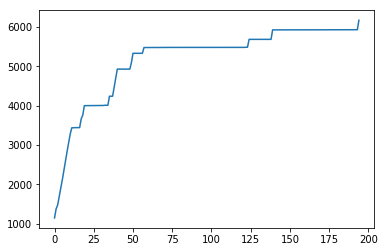

In [180]:
users_met = []
range_of_influence = []
for i in range(5,200):
    targets = list(OrderedDict(sorted(nx.eigenvector_centrality_numpy(g2).items(),
                                        key=itemgetter(1),
                                        reverse=True)).keys())[:i]
    for node in targets:
        try:
            followers = g.neighbors(node)
        except:
            break

        range_of_influence.append(list(followers))
    
    range_of_influence = set([item for sublist in range_of_influence for item in sublist])
    range_of_influence = list(range_of_influence)
    subby = g.subgraph(range_of_influence)
    users_met.append(len(subby.nodes()))
    
plt.plot(users_met)
    
    

In [257]:
targets = list(OrderedDict(sorted(nx.eigenvector_centrality_numpy(g2).items(),
                                        key=itemgetter(1),
                                        reverse=True)).keys())[:50]

for node in targets:
    try:
        followers = g.neighbors(node)
    except:
        break

    range_of_influence.append(list(followers))

range_of_influence = set([item for sublist in range_of_influence for item in sublist])
range_of_influence = list(range_of_influence)
subby = g.subgraph(range_of_influence)


one = sorted(subby.degree(), key=lambda x:x[1], reverse=True)[:30]
one_nodes = [i[0] for i in one]

two = sorted(undirected_graph.degree(), key=lambda x:x[1], reverse=True)[:30]
two_nodes = [i[0] for i in two]

In [260]:

for node in one_nodes:
    try:
        followers = g.neighbors(node)
    except:
        break

    range_of_influence.append(list(followers))

range_of_influence = set([item for sublist in range_of_influence for item in sublist])
range_of_influence = list(range_of_influence)
subby = g.subgraph(range_of_influence)
len(subby.nodes())

5845

In [249]:
list(set(two_nodes) - set(one_nodes))


['dale_l_sheehan',
 'ZachBoychuk',
 'AzorcanGlobal',
 'BobbyNickParody',
 'TrackerFlames',
 'sidepix',
 'SpencerWeaver13',
 'TLaboucan72',
 'WTPuckHockey',
 'ChuckinNucksPod']

In [250]:
list(set(one_nodes) - set(two_nodes))

['turkeynator_85',
 'JC_in_Calgary',
 'TeamLG3',
 'sam_corea',
 'Oil_Drop',
 'Kinger999',
 'ChadMulligan',
 'zjlaing',
 'CrazySteveC',
 'Tkachukyou']

list (set (un _nœuds) - set (deux_ nœuds))

In [251]:
one_nodes

['JC_in_Calgary',
 'Tkachukyou',
 'zjlaing',
 'CrazySteveC',
 'sam_corea',
 'ChadMulligan',
 'Kinger999',
 'TeamLG3',
 'turkeynator_85',
 'Oil_Drop']

In [252]:
two_nodes

['AzorcanGlobal',
 'ZachBoychuk',
 'WTPuckHockey',
 'BobbyNickParody',
 'SpencerWeaver13',
 'TrackerFlames',
 'sidepix',
 'TLaboucan72',
 'dale_l_sheehan',
 'ChuckinNucksPod']